In [5]:
# from google.colab import drive
# drive.mount('/content/drive')

# v3.1

## 데이터 불러오기

In [6]:
# %pip install category_encoders

In [7]:
# %pip install optuna

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.feature_selection import SelectKBest, SelectPercentile, SelectFromModel

In [9]:
DATA_PATH = "/content/drive/MyDrive/멋쟁이사자처럼/Final_Project/dataset/"
SEED = 42

In [10]:
train_ft = pd.read_csv(f"{DATA_PATH}train_common_v3.1_1106.csv")
test_ft = pd.read_csv(f"{DATA_PATH}test_common_v3.1_1106.csv")
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv")
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv")

train_ft.shape, test_ft.shape, train_target.shape, submit.shape

((14940, 1520), (12225, 1520), (14940, 2), (12225, 2))

## 결측치 처리

In [11]:
train_ft.isnull().sum().sum(), test_ft.isnull().sum().sum()

(0, 0)

## 피처 공학 및 스케일링

In [12]:
# ID 제거
train_ft = train_ft.iloc[:,1:]
test_ft = test_ft.iloc[:,1:]
train_ft.shape, test_ft.shape

((14940, 1519), (12225, 1519))

In [13]:
cols = train_ft.select_dtypes("object").columns.tolist()
train_ft[cols].nunique()

,0
주구매지점,4
주구매_대분류,22
주구매_중분류,246


In [14]:
enc = ce.one_hot.OneHotEncoder()
tmp = enc.fit_transform(train_ft["주구매지점"])
train_ft = pd.concat([train_ft,tmp],axis =1)

tmp = enc.transform(test_ft["주구매지점"])
test_ft = pd.concat([test_ft,tmp],axis =1)

train_ft.shape, test_ft.shape

((14940, 1523), (12225, 1523))

In [15]:
enc = ce.count.CountEncoder()
train_ft["주구매_중분류_cnt"] = enc.fit_transform(train_ft[["주구매_중분류"]])
test_ft["주구매_중분류_cnt"] = enc.transform(test_ft[["주구매_중분류"]])

train_ft["주구매_대분류_cnt"] = enc.fit_transform(train_ft[["주구매_대분류"]])
test_ft["주구매_대분류_cnt"] = enc.transform(test_ft[["주구매_대분류"]])

train_ft.shape, test_ft.shape

((14940, 1525), (12225, 1525))

In [16]:
train_ft = train_ft.drop(columns=cols)
test_ft = test_ft.drop(columns=cols)
train_ft.shape, test_ft.shape

((14940, 1522), (12225, 1522))

In [17]:
train_ft["18시_21시_구매비율"] = train_ft["18시_21시_구매비율"] * 3
train_ft["18시_21시_구매횟수"] = train_ft["18시_21시_구매횟수"] * 3

test_ft["18시_21시_구매비율"] = test_ft["18시_21시_구매비율"] * 3
test_ft["18시_21시_구매횟수"] = test_ft["18시_21시_구매횟수"] * 3

In [18]:
scaler = StandardScaler()

train_ft[train_ft.columns] = scaler.fit_transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)
train_ft.head()

,내점일수,구매주기,주말방문비율,평일방문비율,주말방문횟수,평일방문횟수,봄_구매비율,여름_구매비율,가을_구매비율,겨울_구매비율,...,공휴일_대분류_영플라자_구매횟수,공휴일_대분류_잡화_구매횟수,공휴일_대분류_케주얼_구두_아동_구매횟수,공휴일_대분류_패션잡화_구매횟수,주구매지점_1,주구매지점_2,주구매지점_3,주구매지점_4,주구매_중분류_cnt,주구매_대분류_cnt
0,-0.369867,0.002987,0.257728,-0.257728,-0.230862,-0.390544,-1.029777,0.001191,0.838272,0.338186,...,-0.162079,-0.286379,-0.209907,-0.213001,1.654066,-0.623175,-0.612523,-0.468181,-0.726970,-1.315250
1,0.144110,-0.356452,-1.008554,1.008554,-0.619841,0.412809,0.323951,-0.390607,0.620171,-0.552996,...,2.389509,-0.286379,-0.209907,4.161199,-0.604571,1.604686,-0.612523,-0.468181,-0.510078,-0.626416
2,1.943028,-0.869935,0.036742,-0.036742,1.616788,1.926821,0.798943,-0.514333,-0.304527,-0.059266,...,-0.162079,-0.286379,-0.209907,-0.213001,-0.604571,-0.623175,1.632592,-0.468181,-0.848408,1.064726
3,3.793345,-1.023980,-0.080558,0.080558,3.172703,4.429574,0.420933,-0.327474,0.008592,-0.135636,...,10.044273,-0.286379,1.301424,-0.213001,1.654066,-0.623175,-0.612523,-0.468181,1.523851,-0.248364
4,0.452496,-0.613193,0.302875,-0.302875,0.838830,0.567300,-0.752532,1.707410,-0.130285,-0.821561,...,-0.162079,4.377687,4.324087,-0.213001,1.654066,-0.623175,-0.612523,-0.468181,-0.833157,1.064726


In [19]:
target = train_target["target"]

In [20]:
train_ft.shape, test_ft.shape

((14940, 1522), (12225, 1522))

## cv 점수 확인해보기

In [21]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score

params = {'n_estimators': 800,
 'learning_rate': 0.04036413044768581,
 'max_depth': 4,
 'min_child_weight': 7,
 'subsample': 0.7505214930635562,
 'colsample_bytree': 0.6290102054237857,
 'gamma': 0.648553153047272}

# F1 매크로 스코어와 모델을 저장할 리스트
scores = []
models = []

# Stratified K-Fold 교차 검증 설정
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 교차 검증 루프
for tri, vai in cv.split(train_ft, target):
    # 학습 데이터와 검증 데이터 분리
    x_train = train_ft.iloc[tri]
    y_train = target.iloc[tri]
    x_valid = train_ft.iloc[vai]
    y_valid = target.iloc[vai]

    # 모델 초기화 및 학습
    model = XGBClassifier(**params)
    model.fit(x_train, y_train, eval_set=[(x_valid, y_valid)], verbose=False)

    # 모델 저장
    models.append(model)

    # 예측 및 F1 매크로 스코어 계산
    pred = model.predict(x_valid)
    score = f1_score(y_valid, pred, average='macro')
    scores.append(score)

# F1 매크로 스코어의 평균 출력
print("Mean F1 Macro Score:", np.mean(scores))

Mean F1 Macro Score: 0.7189264446483328


## 피처 셀렉션

In [22]:
from sklearn.feature_selection import SelectKBest, SelectPercentile

model = LogisticRegression(random_state=42)

sk = SelectKBest(k=400) # 상위 피처 400개 선택
x = sk.fit_transform(train_ft, target)
scores = cross_val_score(model, x, target, cv=cv, scoring="f1_macro", n_jobs=-1)
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1227 1231 1246 1306 1338 1386 1387 1395 1417 1437 1447 1450] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


0.709526532729473

In [ ]:
# sk.get_feature_names_out()

In [23]:
sp = SelectPercentile(percentile=25) # 상위 25% 피처 선택
x = sp.fit_transform(train_ft, target)
scores = cross_val_score(model, x, target, cv=cv, scoring="f1_macro", n_jobs=-1)
scores.mean()

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1227 1231 1246 1306 1338 1386 1387 1395 1417 1437 1447 1450] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


0.7095419607889969

In [ ]:
# sp.get_feature_names_out()

In [24]:
from tqdm.notebook import tqdm
model = LogisticRegression(random_state=42)

scores = []
for percentile in tqdm(range(1,101)):
    sp = SelectPercentile(percentile=percentile)
    x = sp.fit_transform(train_ft, target)
    score = cross_val_score(model, x, target, cv=cv, scoring="f1_macro", n_jobs=-1).mean()
    scores.append([percentile, score])
scores = np.array(scores)
idx = np.argmax(scores[:,1])
best_score = scores[idx]

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1227 1231 1246 1306 1338 1386 1387 1395 1417 1437 1447 1450] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1227 1231 1246 1306 1338 1386 1387 1395 1417 1437 1447 1450] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1

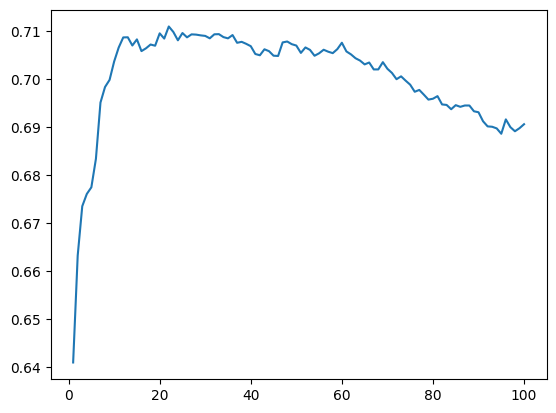

In [25]:
import matplotlib.pyplot as plt

plt.plot(scores[:,0], scores[:,1])
plt.show()

In [26]:
sp = SelectPercentile(percentile=best_score[0])
sp.fit(train_ft,target)
best_cols = sp.get_feature_names_out()
best_cols

/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [1227 1231 1246 1306 1338 1386 1387 1395 1417 1437 1447 1450] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


array(['내점일수', '구매주기', '주말방문비율', '평일방문비율', '주말방문횟수', '평일방문횟수', '여름_구매비율',
       '겨울_구매비율', '주구매_시간대', '일별평균구매횟수', '거래개월수', '9시_12시_구매비율',
       '12시_15시_구매비율', '18시_21시_구매비율', '9시_12시_구매횟수', '12시_15시_구매횟수',
       '18시_21시_구매횟수', '월초_구매횟수', '월말_구매횟수', '웨딩성수기_구매횟수', '3월_구매비율',
       '6월_구매비율', '7월_구매비율', '1월_구매횟수', '2월_구매횟수', '3월_구매횟수', '4월_구매횟수',
       '5월_구매횟수', '6월_구매횟수', '7월_구매횟수', '8월_구매횟수', '9월_구매횟수', '10월_구매횟수',
       '11월_구매횟수', '12월_구매횟수', '1월_방문횟수', '2월_방문횟수', '3월_방문횟수', '4월_방문횟수',
       '5월_방문횟수', '6월_방문횟수', '7월_방문횟수', '8월_방문횟수', '9월_방문횟수', '10월_방문횟수',
       '11월_방문횟수', '12월_방문횟수', '공휴일_구매유무', '여름휴가_구매유무', '여름휴가_구매비율',
       '연말_구매비율', '공휴일_구매횟수', '여름휴가_구매횟수', '연말_구매횟수', '여름휴가_구매X비율',
       '연말_구매X비율', '1월_총구매금액', '2월_총구매금액', '3월_총구매금액', '4월_총구매금액',
       '5월_총구매금액', '6월_총구매금액', '7월_총구매금액', '8월_총구매금액', '9월_총구매금액',
       '10월_총구매금액', '11월_총구매금액', '12월_총구매금액', '5월_평균구매금액', '6월_평균구매금액',
       '7월_평균구매금액', '8월_평균구매금액', '10월_평균구매금액', '웨딩성수기_저가_구매횟수',
       '웨딩성수기_중저가_

In [33]:
len(best_cols)

335

## Logistic Regression

In [27]:
def objective(trial):
    hp = {
        "C": trial.suggest_float("C", 1e-4, 10.0, log=True),  # 규제 강도
        "penalty": "l2",  # L2 규제로 고정
        "solver": trial.suggest_categorical("solver", ["lbfgs", "liblinear", "sag", "saga"]),
        "max_iter": trial.suggest_int("max_iter", 50, 500, step=50)  # 반복 횟수
    }
    cv = KFold(5, shuffle=True, random_state=SEED)
    model = LogisticRegression(**hp, random_state=SEED)
    score = cross_val_score(model, train_ft[best_cols], target, cv=cv, scoring="f1_macro", n_jobs=-1).mean()
    return score

sampler = optuna.samplers.TPESampler(seed=SEED) # 대체 모델 역할은 sampler 객체

# study 객체
study = optuna.create_study(
    direction="maximize",
    sampler = sampler
)

study.optimize(objective, n_trials=100)   # optimze 메서드에 콜백 함수(objective) 전달

[I 2024-11-07 08:47:40,483] A new study created in memory with name: no-name-34df51ab-5972-4d86-8639-83a6a3828b58
[I 2024-11-07 08:47:44,927] Trial 0 finished with value: 0.7119820655856499 and parameters: {'C': 0.0074593432857265485, 'solver': 'lbfgs', 'max_iter': 100}. Best is trial 0 with value: 0.7119820655856499.
[I 2024-11-07 08:47:46,418] Trial 1 finished with value: 0.6910457709212675 and parameters: {'C': 0.00019517224641449495, 'solver': 'lbfgs', 'max_iter': 500}. Best is trial 0 with value: 0.7119820655856499.
[I 2024-11-07 08:49:58,707] Trial 2 finished with value: 0.7085122160438774 and parameters: {'C': 1.452824663751602, 'solver': 'saga', 'max_iter': 300}. Best is trial 0 with value: 0.7119820655856499.
[I 2024-11-07 08:50:05,684] Trial 3 finished with value: 0.7122936859420457 and parameters: {'C': 0.01444525102276306, 'solver': 'liblinear', 'max_iter': 200}. Best is trial 3 with value: 0.7122936859420457.
[I 2024-11-07 08:50:09,540] Trial 4 finished with value: 0.71100

In [28]:
# 최적의 하이퍼파라미터 출력
print("Best hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)

Best hyperparameters: {'C': 0.0005165773180037776, 'solver': 'liblinear', 'max_iter': 100}
Best F1 Score: 0.7191655276220026


In [29]:
# 모델 학습
model = LogisticRegression(random_state=SEED, **study.best_params)
model.fit(train_ft[best_cols],target)

pred = model.predict(test_ft[best_cols])

submit["target"] = pred
submit.to_csv(f"{DATA_PATH}6_v3.1_Logistic.csv",index=False)

## LDA

In [30]:
def objective(trial):
    # Optuna가 선택할 수 있는 하이퍼파라미터 정의
    solver = trial.suggest_categorical('solver', ['svd', 'lsqr', 'eigen'])

    # 'lsqr'와 'eigen'에서만 shrinkage 하이퍼파라미터가 사용되므로 조건 추가
    if solver in ['lsqr', 'eigen']:
        shrinkage = trial.suggest_float('shrinkage', 0.0, 1.0)
    else:
        shrinkage = None

    # n_components 하이퍼파라미터: 차원 수를 1부터 X의 특성 개수까지
    n_components = trial.suggest_int('n_components', 1, min(train_ft[best_cols].shape[1], len(np.unique(target)) - 1))

    # LDA 모델 정의
    lda = LinearDiscriminantAnalysis(solver=solver, shrinkage=shrinkage, n_components=n_components)

    score = cross_val_score(lda, train_ft[best_cols], target, cv=5, scoring="f1_macro", n_jobs=-1).mean()
    return score

# Optuna study 설정 및 최적화 실행
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=200)

[I 2024-11-07 09:05:27,615] A new study created in memory with name: no-name-259a0444-b2cb-434b-a095-2f0bf147581e
[I 2024-11-07 09:05:32,439] Trial 0 finished with value: 0.7119457001299475 and parameters: {'solver': 'svd', 'n_components': 1}. Best is trial 0 with value: 0.7119457001299475.
[I 2024-11-07 09:05:39,272] Trial 1 finished with value: 0.7119457001299475 and parameters: {'solver': 'svd', 'n_components': 1}. Best is trial 0 with value: 0.7119457001299475.
[I 2024-11-07 09:05:41,635] Trial 2 finished with value: 0.7148010091500553 and parameters: {'solver': 'eigen', 'shrinkage': 0.2529129355672636, 'n_components': 1}. Best is trial 2 with value: 0.7148010091500553.
[I 2024-11-07 09:05:46,257] Trial 3 finished with value: 0.7119457001299475 and parameters: {'solver': 'svd', 'n_components': 1}. Best is trial 2 with value: 0.7148010091500553.
[I 2024-11-07 09:05:48,596] Trial 4 finished with value: 0.7134580730367072 and parameters: {'solver': 'eigen', 'shrinkage': 0.021605146376

In [31]:
print("Best hyperparameters:", study.best_params)
print("Best F1 Score:", study.best_value)

Best hyperparameters: {'solver': 'lsqr', 'shrinkage': 0.4590922279243969, 'n_components': 1}
Best F1 Score: 0.7163499776126546


In [32]:
model = LinearDiscriminantAnalysis(**study.best_params)
model.fit(train_ft[best_cols],target)

pred = model.predict(test_ft[best_cols])

submit["target"] = pred
submit.to_csv(f"{DATA_PATH}6_v3.1_LDA.csv",index=False)